# Matcha-TTS: A fast TTS architecture with conditional flow matching
---
[Shivam Mehta](https://www.kth.se/profile/smehta), [Ruibo Tu](https://www.kth.se/profile/ruibo), [Jonas Beskow](https://www.kth.se/profile/beskow), [Éva Székely](https://www.kth.se/profile/szekely), and [Gustav Eje Henter](https://people.kth.se/~ghe/)

We introduce Matcha-TTS, a new encoder-decoder architecture for speedy TTS acoustic modelling, trained using optimal-transport conditional flow matching (OT-CFM). This yields an ODE-based decoder capable of high output quality in fewer synthesis steps than models trained using score matching. Careful design choices additionally ensure each synthesis step is fast to run. The method is probabilistic, non-autoregressive, and learns to speak from scratch without external alignments. Compared to strong pre-trained baseline models, the Matcha-TTS system has the smallest memory footprint, rivals the speed of the fastest models on long utterances, and attains the highest mean opinion score in a listening test.

Demo Page: https://shivammehta25.github.io/Matcha-TTS \
Code: https://github.com/shivammehta25/Matcha-TTS




In [1]:
import datetime as dt
from pathlib import Path

import IPython.display as ipd
import numpy as np
import soundfile as sf
import torch
from tqdm.auto import tqdm

# Hifigan imports
from matcha.hifigan.config import v1
from matcha.hifigan.denoiser import Denoiser
from matcha.hifigan.env import AttrDict
from matcha.hifigan.models import Generator as HiFiGAN
# Matcha imports
from matcha.models.matcha_tts import MatchaTTS
from matcha.text import sequence_to_text, text_to_sequence
from matcha.utils.model import denormalize
from matcha.utils.utils import get_user_data_dir, intersperse

2025-06-02 22:18:41.708921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748902721.722435    1147 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748902721.726544    1147 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748902721.741512    1147 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748902721.741535    1147 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748902721.741542    1147 computation_placer.cc:177] computation placer alr

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# This allows for real time code changes being reflected in the notebook, no need to restart the kernel

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Filepaths

In [4]:
MATCHA_CHECKPOINT = "/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/Matcha_TTS/logs/train/ljspeech/runs/2025-06-02_14-11-39/checkpoints/checkpoint_epoch=2739.ckpt"
HIFIGAN_CHECKPOINT = "/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/Matcha_TTS/pretrained/generator_v1.ckpt"
OUTPUT_FOLDER = "synth_output"

## Load Matcha-TTS

In [5]:
def load_model(checkpoint_path):
    model = MatchaTTS.load_from_checkpoint(checkpoint_path, map_location=device)
    model.eval()
    return model
count_params = lambda x: f"{sum(p.numel() for p in x.parameters()):,}"


model = load_model(MATCHA_CHECKPOINT)
print(f"Model loaded! Parameter count: {count_params(model)}")

/gpfs0/bgu-benshimo/users/wavishay/env/pythn_new/lib/python3.9/site-packages/diffusers/models/lora.py:393: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)


Model loaded! Parameter count: 18,204,193


## Load HiFi-GAN (Vocoder)

In [6]:
def load_vocoder(checkpoint_path):
    h = AttrDict(v1)
    hifigan = HiFiGAN(h).to(device)
    hifigan.load_state_dict(torch.load(checkpoint_path, map_location=device)['generator'])
    _ = hifigan.eval()
    hifigan.remove_weight_norm()
    return hifigan

vocoder = load_vocoder(HIFIGAN_CHECKPOINT)
denoiser = Denoiser(vocoder, mode='zeros')

/gpfs0/bgu-benshimo/users/wavishay/env/pythn_new/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Removing weight norm...


### Helper functions to synthesise

In [7]:
@torch.inference_mode()
def process_text(text: str):
    x = torch.tensor(intersperse(text_to_sequence(text, ['basic_cleaners'])[0], 0),dtype=torch.long, device=device)[None]
    x_lengths = torch.tensor([x.shape[-1]],dtype=torch.long, device=device)
    x_phones = sequence_to_text(x.squeeze(0).tolist())
    return {
        'x_orig': text,
        'x': x,
        'x_lengths': x_lengths,
        'x_phones': x_phones
    }


@torch.inference_mode()
def synthesise(text, spks=None):
    text_processed = process_text(text)
    start_t = dt.datetime.now()
    output = model.synthesise(
        text_processed['x'], 
        text_processed['x_lengths'],
        n_timesteps=n_timesteps,
        temperature=temperature,
        spks=spks,
        length_scale=length_scale
    )
    # merge everything to one dict    
    output.update({'start_t': start_t, **text_processed})
    return output

@torch.inference_mode()
def to_waveform(mel, vocoder):
    audio = vocoder(mel).clamp(-1, 1)
    audio = denoiser(audio.squeeze(0), strength=0.00025).cpu().squeeze()
    return audio.cpu().squeeze()
    
def save_to_folder(filename: str, output: dict, folder: str):
    folder = Path(folder)
    folder.mkdir(exist_ok=True, parents=True)
    np.save(folder / f'{filename}', output['mel'].cpu().numpy())
    sf.write(folder / f'{filename}.wav', output['waveform'], 22050, 'PCM_24')

## Setup text to synthesise

In [8]:
from HebrewToEnglish import HebrewToEnglish

text = "מָה קוֹרֶה? קוֹרְאִים לִי אֲבִישַׁי וְזֶה הַמְתַמְלֵל שֶׁלִּי."
#text ="לְפָעָמִים, כְּשֶׁהַיּוֹם מִסְתַּיֵּם וְהַשֶּׁקֶט שׁוֹרֵר בַּחֶדֶר, אֲנִי מוֹצֵא אֶת עַצְמִי חוֹשֵׁב עַל כָּל הַדְּבָרִים שֶׁהִסְפַּקְתִּי לַעֲשׂוֹת, עַל הַדְּבָרִים שֶׁעוֹד מַחֲכִים לִי מָחָר, וְעַל כַּמָּה זֶה חָשׁוּב לִפְעָמִים לַעֲצוֹר, לִנְשֹׁם עָמוֹק, וּלְהַכִּיר בַּהַכָּרָה עֲמוּקָה בְּכָל הַדְּקָרִים הַקְּטַנִּים שֶׁמְּרַכְּבִים אֶת הַחַיִּים."
texts = HebrewToEnglish(text)
print(texts)

mahh korehh koriym liy aviyshay vezehh hhamtamlel sheliy q 


### Hyperparameters

In [9]:
## Number of ODE Solver steps
n_timesteps = 10

## Changes to the speaking rate
length_scale = 1

## Sampling temperature
temperature = 0.1

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_mel(mel, title="Mel-Spectrogram"):
    """
    Plots a mel-spectrogram.

    Args:
        mel (np.ndarray or torch.Tensor): Mel spectrogram to plot, shape [n_mels, time].
        title (str): Title of the plot.
    """
    if torch.is_tensor(mel):
        mel = mel.detach().cpu().numpy().squeeze()

    plt.figure(figsize=(10, 4))
    plt.imshow(mel, aspect='auto', origin='lower', interpolation='none')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Mel Bin')
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()


## Synthesis

  0%|          | 0/1 [00:00<?, ?it/s]

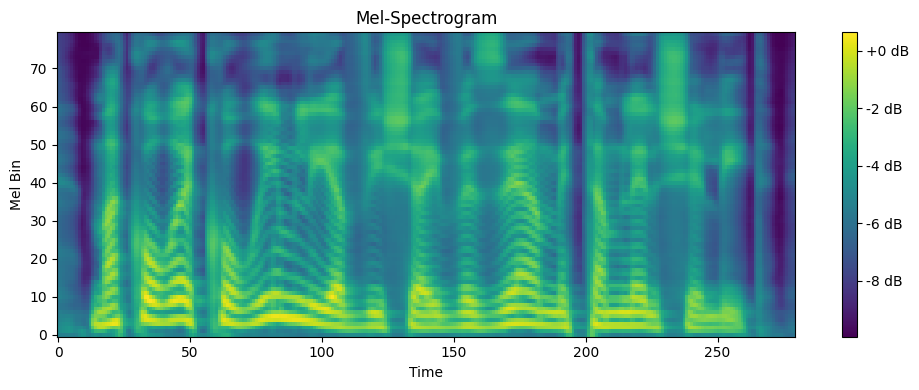

*****************************************************
Input text - 0
-----------------------------------------------------
mahh korehh koriym liy aviyshay vezehh hhamtamlel sheliy q 
*****************************************************
Phonetised text - 0
-----------------------------------------------------
_m_a_h_h_ _k_o_r_e_h_h_ _k_o_r_i_y_m_ _l_i_y_ _a_v_i_y_s_h_a_y_ _v_e_z_e_h_h_ _h_h_a_m_t_a_m_l_e_l_ _s_h_e_l_i_y_ _q_ _
*****************************************************
RTF:		0.186546
RTF Waveform:	0.433530


Number of ODE steps: 10
Mean RTF:				0.186546 ± 0.000000
Mean RTF Waveform (incl. vocoder):	0.433530 ± 0.000000


In [11]:
outputs, rtfs = [], []
rtfs_w = []
for i, text in enumerate(tqdm([texts])):
    output = synthesise(text) #, torch.tensor([15], device=device, dtype=torch.long).unsqueeze(0))
    output['waveform'] = to_waveform(output['mel'], vocoder)
    
    plot_mel(output['mel'])

    # Compute Real Time Factor (RTF) with HiFi-GAN
    t = (dt.datetime.now() - output['start_t']).total_seconds()
    rtf_w = t * 22050 / (output['waveform'].shape[-1])

    ## Pretty print
    print(f"{'*' * 53}")
    print(f"Input text - {i}")
    print(f"{'-' * 53}")
    print(output['x_orig'])
    print(f"{'*' * 53}")
    print(f"Phonetised text - {i}")
    print(f"{'-' * 53}")
    print(output['x_phones'])
    print(f"{'*' * 53}")
    print(f"RTF:\t\t{output['rtf']:.6f}")
    print(f"RTF Waveform:\t{rtf_w:.6f}")
    rtfs.append(output['rtf'])
    rtfs_w.append(rtf_w)

    ## Display the synthesised waveform
    ipd.display(ipd.Audio(output['waveform'], rate=22050))

    ## Save the generated waveform
   # save_to_folder(i, output, OUTPUT_FOLDER)

print(f"Number of ODE steps: {n_timesteps}")
print(f"Mean RTF:\t\t\t\t{np.mean(rtfs):.6f} ± {np.std(rtfs):.6f}")
print(f"Mean RTF Waveform (incl. vocoder):\t{np.mean(rtfs_w):.6f} ± {np.std(rtfs_w):.6f}")

In [12]:
import os 
import sys
# הוספת נתיב המודל
sys.path.insert(0,'/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/Pytorch/BigVGAN/')


device = 'cuda'

import torch
import bigvgan as bigvgan
import librosa
from meldataset import get_mel_spectrogram

# instantiate the model. You can optionally set use_cuda_kernel=True for faster inference.
model = bigvgan.BigVGAN.from_pretrained('nvidia/bigvgan_v2_22khz_80band_fmax8k_256x', use_cuda_kernel=False)

# remove weight norm in the model and set to eval mode
model.remove_weight_norm()
model = model.eval().to(device)

Loading weights from nvidia/bigvgan_v2_22khz_80band_fmax8k_256x
Removing weight norm...


In [13]:
from IPython.display import Audio as ipdAudio
# generate waveform from mel
with torch.inference_mode():
    wav_gen = model(output['mel'].float()) # wav_gen is FloatTensor with shape [B(1), 1, T_time] and values in [-1, 1]
wav_gen_float = wav_gen.squeeze(0).cpu() # wav_gen is FloatTensor with shape [1, T_time]

# you can convert the generated waveform to 16 bit linear PCM
wav_gen_int16 = (wav_gen_float * 32767.0).numpy().astype('int16') # wav_gen is now np.ndarray with shape [1, T_time] and int16 dtype


# ----- השמעה במחברת -----
ipdAudio(wav_gen_float, rate=22050)